# Determining Properties of Galaxies Using Machine Learning

---
## Jorge Bermeo, Nathanael Gutierrez, Tokhirjon Malikov

## Table of Contents
1. [Summary](#abstract)
1. [Learning Set](#learning-set)
1. [Predictions](#predictions)
    1. [Predicting age](#PREDICTING-AGE)
    1. [Predicting tau](#predicting-tau)
    1. [Predicting mass](#PREDICTING-MASS)
    1. [Predicting dust](#predicting-dust)
1. [Adding Noise](#adding-noise)
    1. [Age](#age-noise)
    1. [Tau](#tau-noise)
    1. [Mass](#mass-noise)
    1. [Dust](#dust-noise)
1. [References](#references)

---
## SUMMARY

SUMMARY GOES HERE

---

## LEARNING SET

SHORT DESCRIPTION OF OUR LEARNING SET GOES HERE

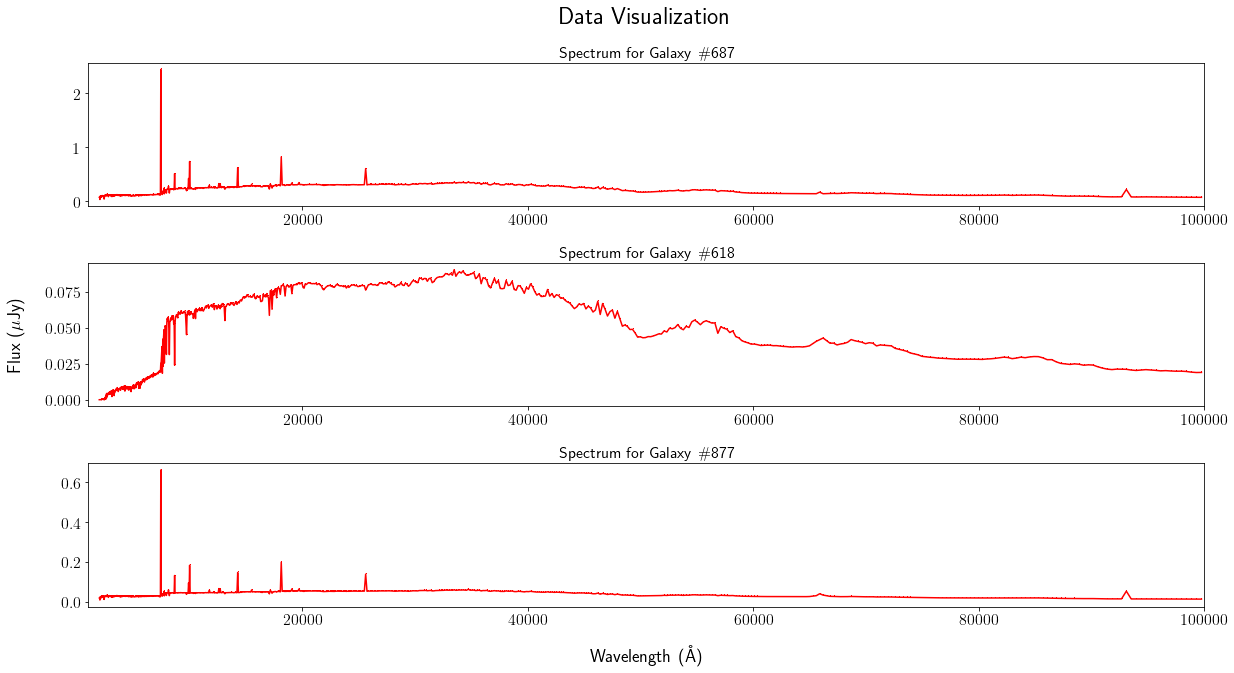

In [47]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import random
%matplotlib inline
matplotlib.rcParams['text.usetex'] = True

spectra = pd.read_csv('spectra.dat', delimiter=' ', header=None)
wavelengths = pd.read_csv('wavelengths.csv', header=None)
galaxy_properties = pd.read_csv('galaxy_properties.csv', index_col = 0)

random.seed(1010) # for reproducibility
rows = [random.randint(0, len(spectra)) for i in range(3)]  # select three random galaxy spectrums to visualize

plt.rcParams["figure.figsize"] = (20,10) #set size of plot
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)

fig = plt.figure()
ax = fig.add_subplot(111) # Generating subplots for our figure; see https://stackoverflow.com/a/6981055/3135556
ax1 = fig.add_subplot(311) # 3 rows, 1 column, plot at position 1
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

# Turn off axis lines and ticks of the big subplot
ax.spines['top'].set_color('none')
ax.spines['bottom'].set_color('none')
ax.spines['left'].set_color('none')
ax.spines['right'].set_color('none')
ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)

ax1.plot(wavelengths, spectra.loc[rows[0]], 'r,-')
ax2.plot(wavelengths, spectra.loc[rows[1]], 'r,-')
ax3.plot(wavelengths, spectra.loc[rows[2]], 'r,-')

ax1.set_xlim(1000, 100000) # restrict the x-axis to mitigate the gap that exists around x=0
ax2.set_xlim(1000, 100000)
ax3.set_xlim(1000, 100000)

# Set common labels
ax.set_xlabel("Wavelength (Å)", fontsize=18, labelpad=18)
ax.set_ylabel("Flux ($\mathrm{\mu}$Jy)", fontsize=18, labelpad=36)
ax.set_title("Data Visualization", fontsize=24, pad=40)

ax1.set_title("Spectrum for Galaxy \#" + str(rows[0]), fontsize=16)
ax2.set_title("Spectrum for Galaxy \#" + str(rows[1]), fontsize=16)
ax3.set_title("Spectrum for Galaxy \#" + str(rows[2]), fontsize=16)

plt.subplots_adjust(hspace=0.4) # increase vertical distance between subplots
fig.savefig("visualization.png")

## Helper functions

In [2]:
def dtt(values, val_type='pd'):
    """
    Do The Thing -- takes the log of the sum of each row in 'values'
    Returns a NumPy array with as many values as the number of rows in 'values'
    
    Positional arguments:
        values -- a Pandas DataFrame or NumPy array
        
    Optional arguments:
        val_type -- 'pd' if 'values' is a Pandas DataFrame, 'np' if 'values' is a NumPy array
    """
    
    X = np.empty(len(values))
    
    if (val_type == 'pd'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values.iloc[i]))
    elif (val_type == 'np'):
        for i in range(len(values)):
            X[i] = np.log(np.sum(values[i]))
    else:
        raise ValueError("Expecting val_type to be either 'pd' or 'np'")
    
    return X

In [122]:
def plot_model_performance(x, y_expected, y_predicted, ylabel, **kwargs):
    params = {
        'actual_color': 'red',
        'predicted_color': 'blue',
        'actual_label': 'Actual values',
        'predicted_label': 'Predicted values',
        'title': 'Model Perfomance',
        'xlabel': '$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$',
        'save_fig': False,
        'save_fig_as': '',
        'scores': None,
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
    
    fig, ax = plt.subplots()
    ax.scatter(X, y_expected, color=params['actual_color'], label=params['actual_label'], alpha=0.6)
    plt.scatter(X, y_predicted, color=params['predicted_color'], label=params['predicted_label'], alpha=0.6)
    ax.legend()
    ax.set_title(params['title'], fontsize=20, pad=10)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=14)
    ax.set_xlabel(params['xlabel'], fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        ax.text(0.01, 0.98, text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if params['save_fig']:
        if params['save_fig_as'] == '':
            params['save_fig_as'] = 'Model Performance - ' + ylabel
        fig.savefig(params['save_fig_as'], dpi=300)

In [119]:
def plot_model_training_performance(X_train, X_test, y_train, y_test, y_predict, ylabel, **kwargs):
    params = {
        'train_color': 'silver',
        'test_actual_color': 'red',
        'test_predicted_color': 'blue',
        'train_label': 'Training data',
        'test_actual_label': 'Test data (actual)',
        'test_predicted_label': 'Test data (predicted)',
        'title': 'Model Training Perfomance',
        'xlabel': '$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$',
        'save_fig': False,
        'save_fig_as': None,
        'scores': None,
    }
    
    for key, value in kwargs.items():
        if key not in params:
            raise ValueError("Keyword argument '" + key + "' not in list of acceptable parameters.")
        params[key] = value
        
    xtrain = dtt(X_train, val_type='pd')
    xtest = dtt(X_test, val_type='pd')
    
    fig, ax = plt.subplots()
    ax.scatter(xtrain, y_train, color=params['train_color'], label=params['train_label'], s=20)
    ax.scatter(xtest, y_test, color=params['test_actual_color'], label=params['test_actual_label'], alpha=0.6, s=50)
    ax.scatter(xtest, y_predict, color=params['test_predicted_color'], label=params['test_predicted_label'], alpha=0.6, s=50)
    ax.legend()
    ax.set_title(params['title'], fontsize=20, pad=10)
    ax.set_ylabel(ylabel, fontsize=16, labelpad=14)
    ax.set_xlabel(params['xlabel'], fontsize=16, labelpad=14)
    
    if params['scores'] is not None:
        props = dict(boxstyle='round', facecolor='silver', alpha=0.5)
        text = 'Training Results\n\n'
        for key, value in params['scores'].items():
            text = text + ' = '.join((key, '%.3f' % (value, ))) + '\n'
        ax.text(0.01, 0.98, text, transform=ax.transAxes, fontsize=14, verticalalignment='top', bbox=props)
    
    if params['save_fig']:
        if params['save_fig_as'] == None:
            params['save_fig_as'] = 'Model Training Performance - ' + ylabel
        fig.savefig(params['save_fig_as'], dpi=300)

In [102]:
def visualize(Y, ylabel, title, X=spectra_X, xlabel='$\log (\sum\limits_{i\in\{\mathrm{Spectrum}\}} \mathrm{Spectrum}_i)$', save_fig=False, save_as=None):
    plt.scatter(X, Y)
    plt.title(title, fontsize=20, pad=10)
    plt.xlabel(xlabel, fontsize=16, labelpad=14)
    plt.ylabel(ylabel, fontsize=16, labelpad=14)
    if save_fig == True:
        if save_as == None:
            save_as = title
        plt.savefig(save_as, dpi=300)

In [103]:
spectra_X = dtt(spectra)

## PREDICTING AGE

SHORT BLURB GOES HERE

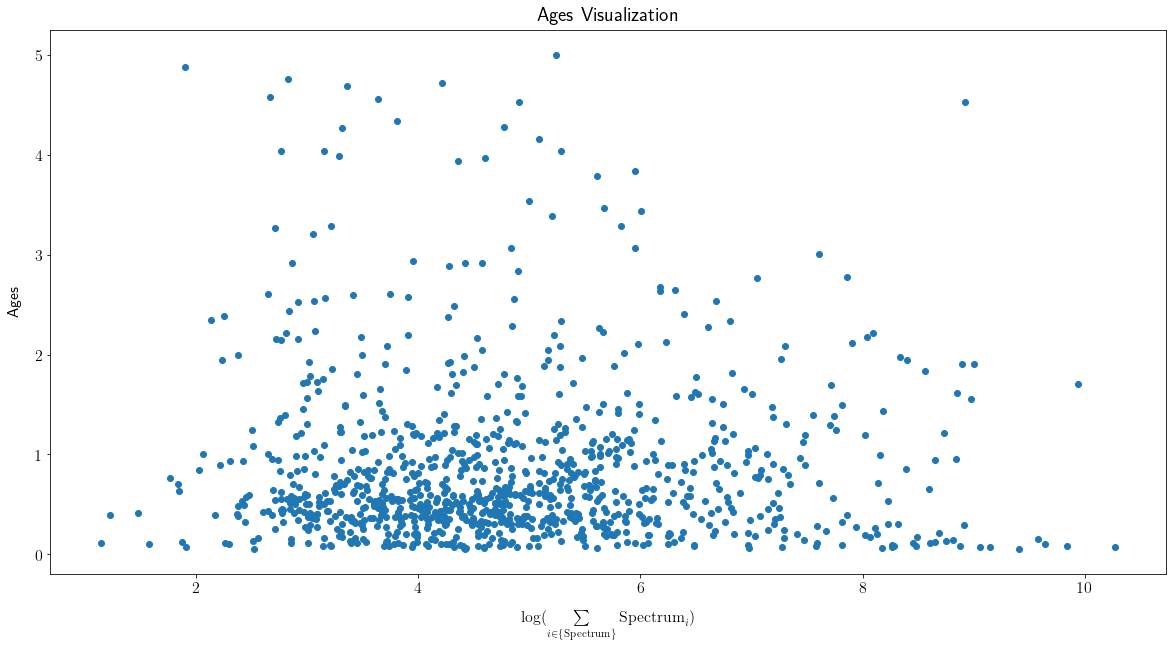

In [116]:
ages = galaxy_properties['age']
visualize(ages, 'Ages', 'Ages Visualization', save_fig=True)

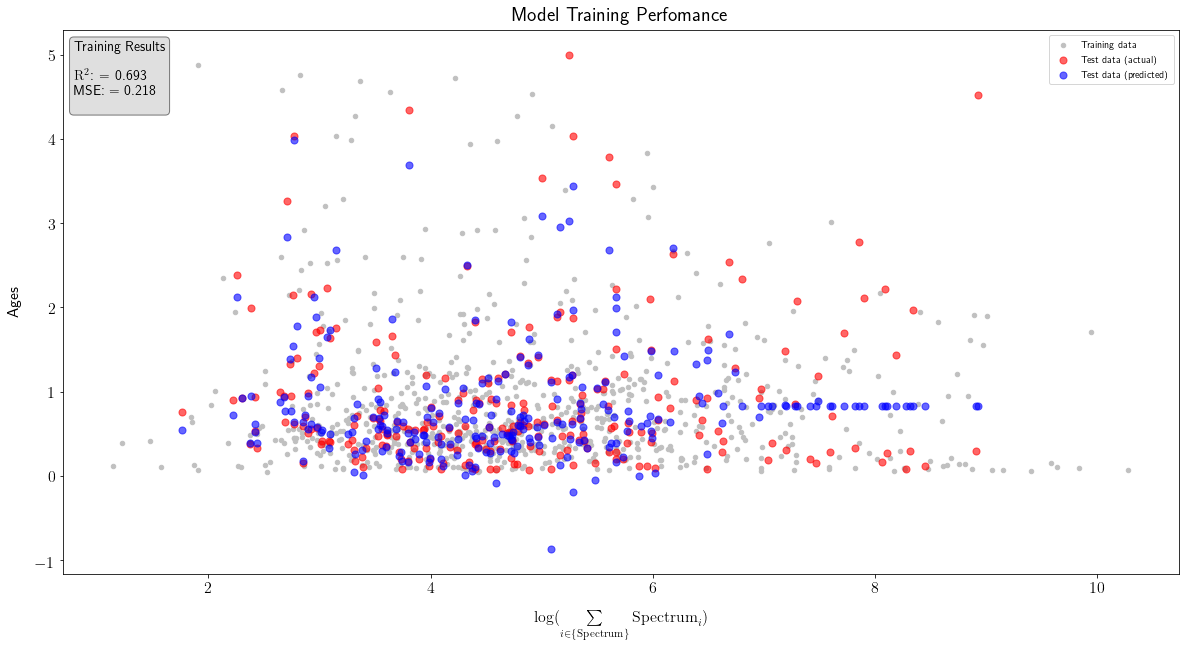

In [120]:
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVR

X_train, X_test, y_train, y_test = train_test_split(spectra, ages, random_state=101)
age_model = SVR(C=2300, gamma=0.08, kernel='rbf')
age_model.fit(X_train, y_train)
prediction = age_model.predict(X_test)

scores = {
    '$\mathrm{R}^2$: ': r2_score(y_test, prediction),
    'MSE: ': mean_squared_error(y_test, prediction)
}

plot_model_training_performance(X_train, X_test, y_train, y_test, prediction, 'Ages', scores=scores, save_fig=True)

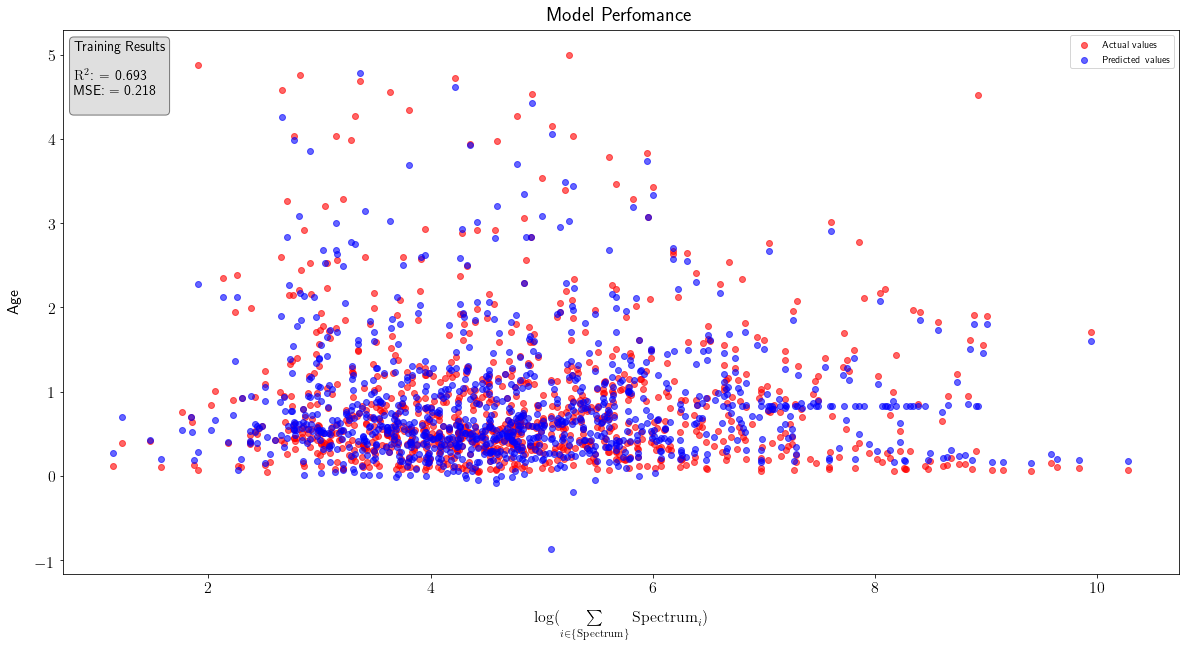

In [124]:
plot_model_performance(spectra_X, ages, age_model.predict(spectra), 'Age', scores=scores, save_fig=True)

## PREDICTING MASS

SHORT BLURB GOES HERE

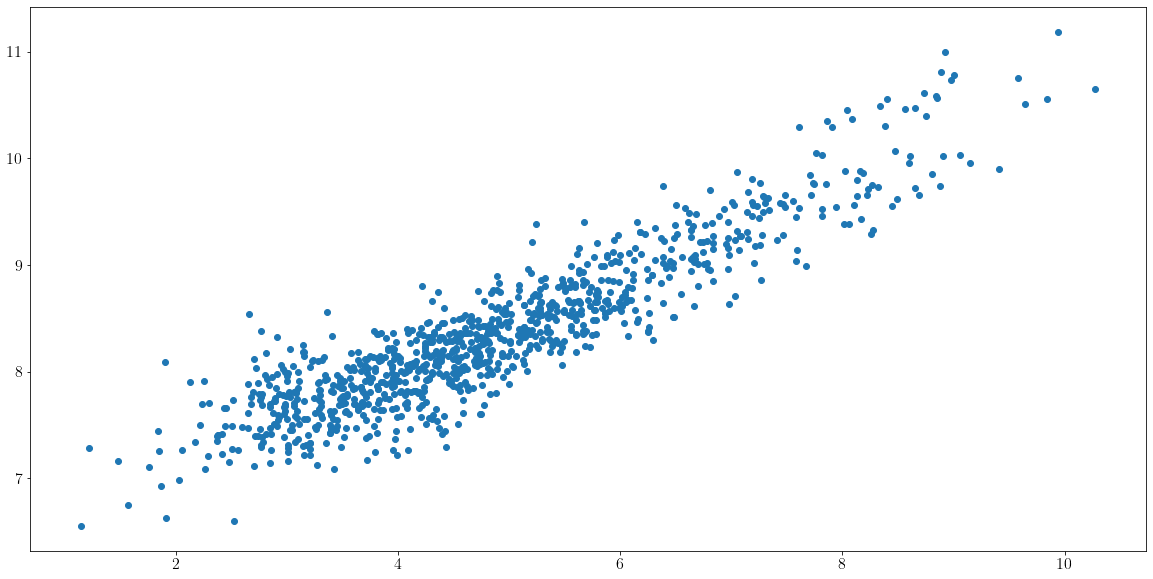

In [43]:
# TODO: LABEL GRAPH
mass = galaxy_properties['mass']

X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plt.scatter(X, mass)

0.9472584881504672
0.02523319494593568


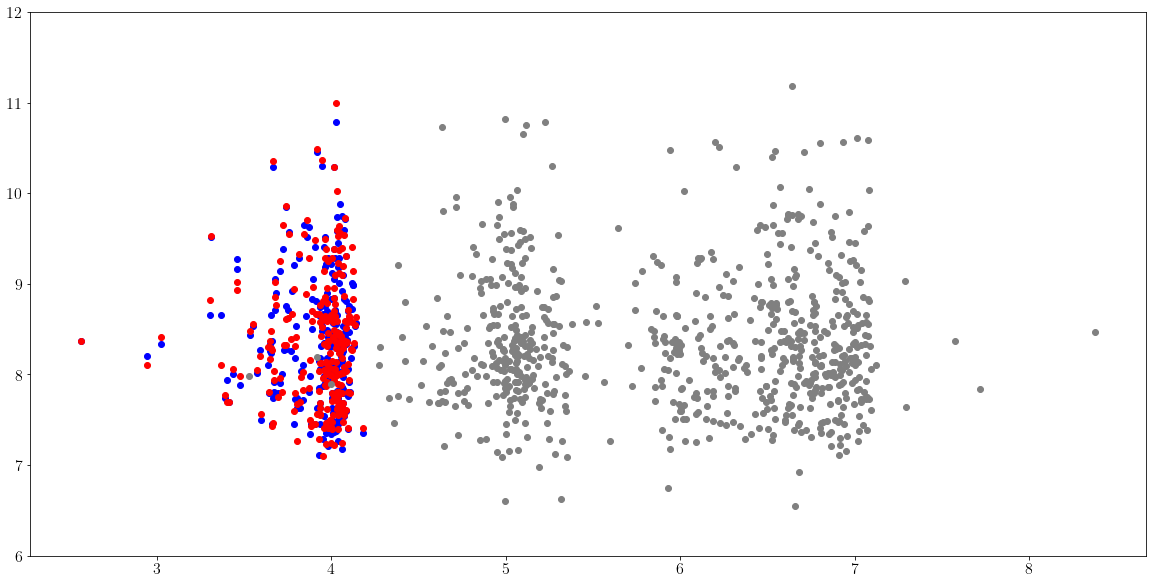

In [44]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(spectra, mass, random_state = 101)
mass_model = DecisionTreeRegressor(max_features=803)
mass_model.fit(X_train, y_train)

prediction = mass_model.predict(X_test)

X = np.empty(len(X_test))
X2 = np.empty(len(X_train))

for i in range(len(X_test)):
    X[i] = np.log(np.sum(X_test[i]))
    
for i in range(len(X_train)):
    X2[i] = np.log(np.sum(X_train[i]))

plt.ylim(6, 12)
plt.scatter(X, prediction, c='blue')
plt.scatter(X, y_test, c='red')
plt.scatter(X2, y_train, c='grey')

print(r2_score(y_test, prediction))
print(mean_squared_error(y_test, prediction))

In [ ]:
X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plot_model_performance(X, mass, mass_model.predict(spectra), 'Mass')

## PREDICTING TAU

SHORT BLURB GOES HERE

In [ ]:
tau = galaxy_properties['tauGyr']

X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plt.scatter(X, tau)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(spectra, tau, random_state=101)
tau_model = SVR(C=10, gamma=16, kernel='rbf')
tau_model.fit(X_train, y_train)
print(r2_score(y_test, tau_model.predict(X_test)))
print(mean_squared_error(y_test, tau_model.predict(X_test)))

X = np.empty(len(X_train))
for i in range(len(X_train)):
    X[i] = np.log(np.sum(X_train[i]))
    
X2 = np.empty(len(X_test))
for i in range(len(X_test)):
    X2[i] = np.log(np.sum(X_test[i]))

fig, ax = plt.subplots()
ax.scatter(X, y_train, color='gray', label='Training data')
ax.scatter(X2, y_test, color='red', label='Test data (actual)')
ax.scatter(X2, tau_model.predict(X_test), color='blue', label='Test data (predicted)')
ax.legend()
ax.set_title("Model Performance", fontsize=16)
plt.show()
fig.savefig("model_perfomance", dpi=300)

In [ ]:
X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plot_model_performance(X, tau, tau_model.predict(spectra), 'Tau')

## PREDICTING DUST

SHORT BLURB GOES HERE

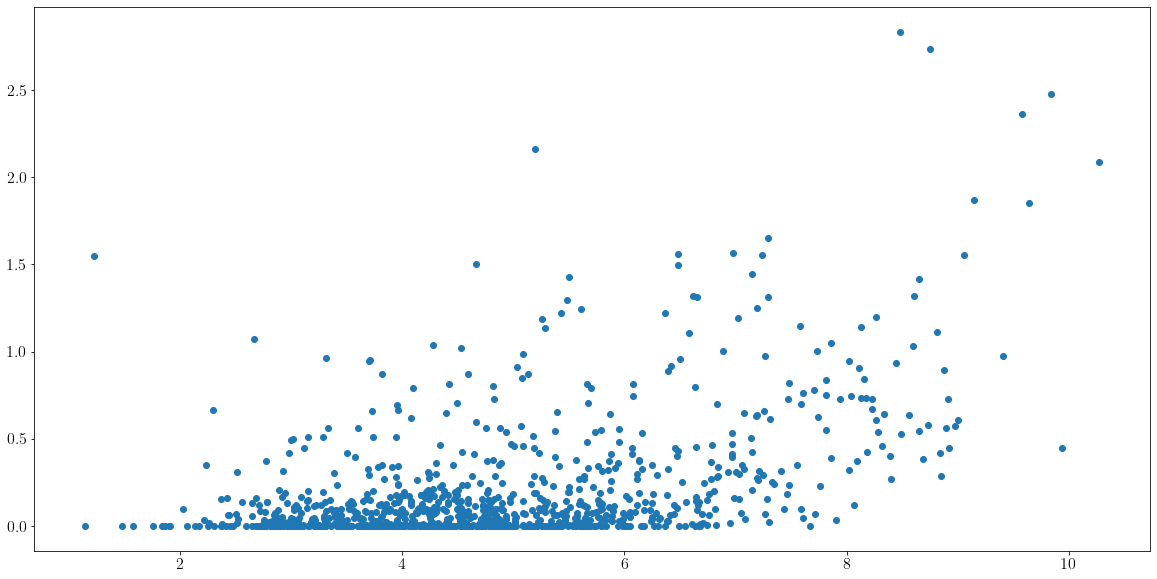

In [50]:
dust = galaxy_properties['dust_av']

X = np.empty(len(spectra))
for i in range(len(spectra)):
    X[i] = np.log(np.sum(spectra.loc[i]))

plt.scatter(X, dust)

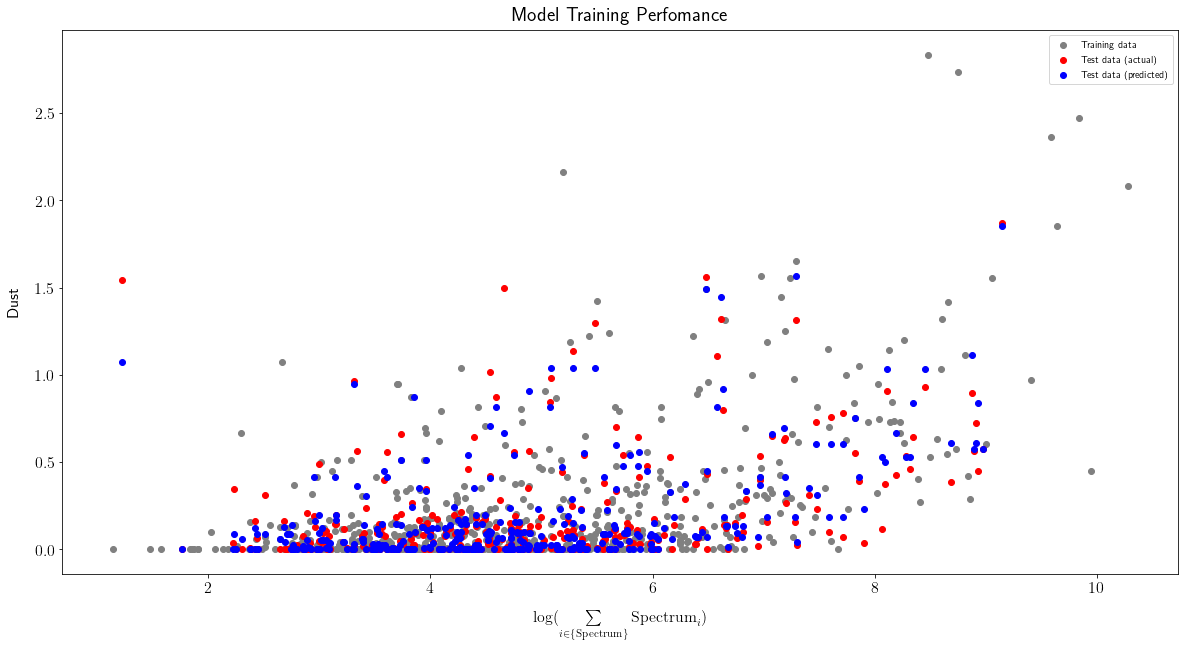

In [55]:
dust_model = DecisionTreeRegressor(max_features=800)

X_train, X_test, y_train, y_test = train_test_split(spectra, dust, train_size=0.65,test_size=0.35, random_state=101)
dust_model.fit(X_train, y_train)
prediction = dust_model.predict(X_test)

plot_model_training_performance(X_train, X_test, y_train, y_test, prediction, 'Dust', save_fig=True)

In [53]:
print(r2_score(y_test, dust_model.predict(X_test)))
print(mean_squared_error(y_test, dust_model.predict(X_test)))

0.6997694474017105
0.025908668899228562


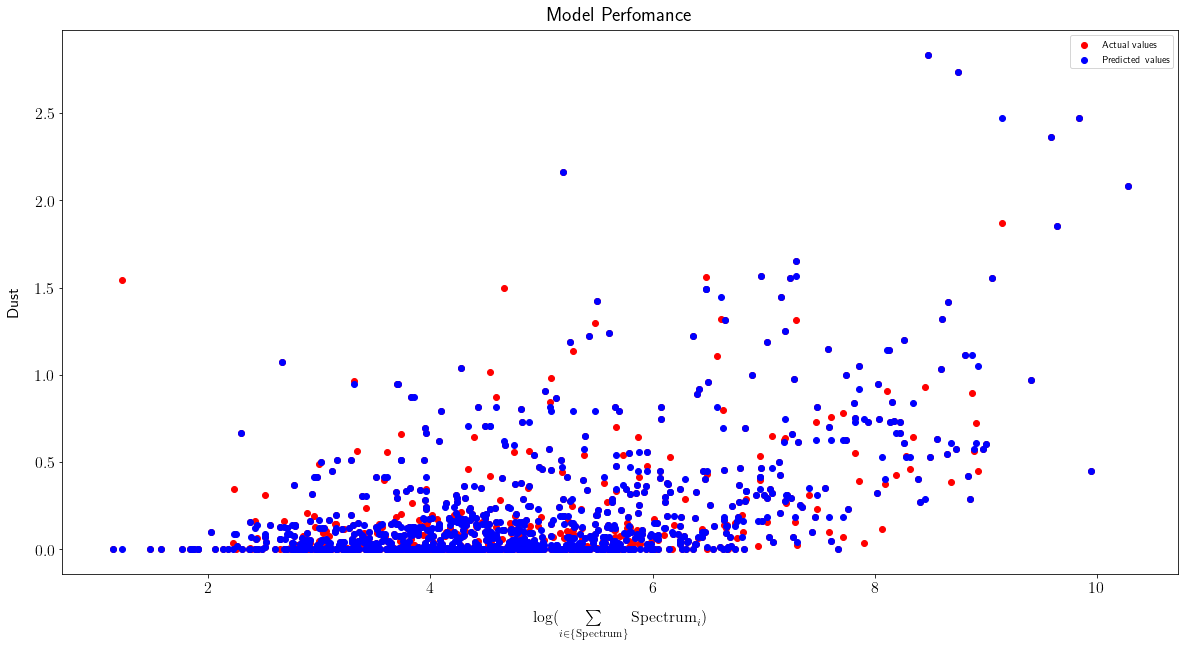

In [54]:
plot_model_performance(X, dust, dust_model.predict(spectra), 'Dust')

## ADDING NOISE

In [ ]:
import scipy.stats

def add_noise(df, percent):
    """
    Add a percetange of noise to a Pandas DataFrame.
    Returns a new Pandas DataFrame containing the noise.
    
    Positional arguments:
    - df : a Pandas DataFrame
    - percent: percentage of noise desired, as a float. 
               For example, a value of 0.10 is 10%. 
               Similarly a value of 1.15 is 115%. 
    """
    ndf = pd.DataFrame()
    for i in range(len(df.columns)):
        mean = df[i] * percent
        gauss_dist = scipy.stats.norm.rvs(loc=0, scale=0.005, size=1000)
        ndf[i] = df[i] + np.abs(gauss_dist)
        
    return ndf

In [ ]:
spectra_1 = add_noise(spectra, 0.01)
spectra_5 = add_noise(spectra, 0.05)
spectra_10 = add_noise(spectra, 0.1)

In [ ]:
plot_model_performance(X, ages, age_model.predict(spectra_1), 'Age')
print("mse: ", mean_squared_error(ages, age_model.predict(spectra)))
print("mse noise: ", mean_squared_error(ages, age_model.predict(spectra_1)))

In [ ]:
plot_model_performance(X, ages, age_model.predict(spectra_5), 'Age')
print("mse: ", mean_squared_error(ages, age_model.predict(spectra)))
print("mse noise: ", mean_squared_error(ages, age_model.predict(spectra_5)))

In [ ]:
plot_model_performance(X, ages, age_model.predict(spectra_10), 'Age')

In [ ]:
plot_model_performance(X, tau, tau_model.predict(spectra_1), 'Tau')

In [ ]:
plot_model_performance(X, tau, tau_model.predict(spectra_5), 'Tau')

In [ ]:
plot_model_performance(X, tau, tau_model.predict(spectra_10), 'Tau')

In [ ]:
plot_model_performance(X, mass, mass_model.predict(spectra_1), 'Mass')

In [ ]:
plot_model_performance(X, mass, mass_model.predict(spectra_5), 'Mass')

In [ ]:
plot_model_performance(X, mass, mass_model.predict(spectra_10), 'Mass')

In [ ]:
plot_model_performance(X, dust, dust_model.predict(spectra_1), 'Dust')

In [ ]:
plot_model_performance(X, dust, dust_model.predict(spectra_5), 'Dust')

In [ ]:
plot_model_performance(X, dust, dust_model.predict(spectra_10), 'Dust')